In [1]:
#@title Runtime
use_tpu = False #@param

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os
import tensorflow as tf
import urllib
from dataclasses import dataclass
import tensorflowjs as tfjs
# import tensorflow_decision_forests as tfdf
import json
from tqdm import tqdm
import seaborn as sns
np.random.seed(0)

In [3]:
urllib.request.urlretrieve(
    "https://github.com/ur-whitelab/peptide-dashboard/raw/master/ml/data/human-positive.npz",
    "positive.npz",
)
urllib.request.urlretrieve(
    "https://github.com/ur-whitelab/peptide-dashboard/raw/master/ml/data/human-negative.npz",
    "negative.npz",
)
with np.load("positive.npz") as r:
    pos_data = r[list(r.keys())[0]]
with np.load("negative.npz") as r:
    neg_data = r['seqs']
    weights = r['weights']

# create labels and stich it all into one
# tensor
# labels = np.concatenate(
#     (
#         np.ones((pos_data.shape[0], 1), dtype=pos_data.dtype),
#         np.zeros((neg_data.shape[0], 1), dtype=pos_data.dtype),
#     ),
#     axis=0,
# )
# weights = np.concatenate(
#     (np.ones((pos_data.shape[0]), dtype=pos_data.dtype), 
#      weights)
# )
# features = np.concatenate((pos_data, neg_data), axis=0)
# pos_data_lengths = np.count_nonzero(pos_data, axis=1)
# neg_data_lengths = np.count_nonzero(neg_data, axis=1)

In [6]:
def encoder(seq, max_length=200):
    alphabet = ['A','R','N','D','C','Q','E','G','H','I', 'L','K','M','F','P','S','T','W','Y','V']
    vec = np.zeros(max_length)
    for i,l in enumerate(seq):
        vec[i] = alphabet.index(l) + 1
    return vec
# sample unlabeled data
def sample_permutations_from_vec(data_lengths, labeled_unlabeled_ratio=0.2, max_sequence_length=200):
    alphabet = ['A','R','N','D','C','Q','E','G','H','I', 'L','K','M','F','P','S','T','W','Y','V']
    with open("../pdb_dist.txt", 'r') as f:
        # the probabilities in this file are sorted based on the alphabet list above
        pdb_dist = f.read().split()
        pdb_dist = [float(item) for item in pdb_dist]
#     unlabeled_seq_lengths = vec_pep_length(positive_data, ohe_vec=False)
#     print(unlabeled_seq_lengths)
    sampled_lengths = []
    for length in data_lengths:
        length_sample_batch = np.ones(int(1/labeled_unlabeled_ratio), dtype=int) * length
        sampled_lengths.append(length_sample_batch)
    sampled_lengths = np.array(sampled_lengths).flatten()
    sampled_sequences = []
    sampled_vecs = []
    for length in tqdm(sampled_lengths):
#         print(length)
    #         random_alphabet_index = np.random.randint(len(alphabet), size=length)
        # sample alphabet index based on weighted amino acid frequencies in pdb
        random_alphabet_index = np.random.choice(len(alphabet), size=length, p=pdb_dist)
        for _ in range(length):
            pep = ''.join([alphabet[m] for m in random_alphabet_index])
        vec_pep = encoder(pep)
        # pad zeros
    #     print(ohe_pep.shape)
#         ohe_pep = np.concatenate([ohe_pep, np.zeros((max_sequence_length-ohe_pep.shape[0],20))],axis=0)
        sampled_vecs.append(vec_pep)
        sampled_sequences.append(pep)
#     sampled_vecs = np.array(sampled_vecs)
    return sampled_sequences, sampled_vecs
# ohe_sequence_list = np.concatenate([ohe_sequence_list, np.zeros((190,10))],axis=1)
pos_data_lengths = np.count_nonzero(pos_data, axis=1) + 1
neg_data_lengths = np.count_nonzero(neg_data, axis=1) + 1
labeled_unlabeled_ratio = 0.2
sampled_sequences, sampled_vecs = sample_permutations_from_vec(pos_data_lengths, labeled_unlabeled_ratio=0.2)
sampled_vecs = np.array(sampled_vecs)
# X_unlabeled = sampled_vecs
unlabeled_data_lengths = []
for seq in sampled_sequences:
    unlabeled_data_lengths.append(len(seq))

100%|██████████| 18000/18000 [00:00<00:00, 24777.36it/s]


In [7]:
X_positive = pos_data
X_negative = neg_data
X_unlabeled = sampled_vecs
print('Positive data:', pos_data.shape[0])
print('Negative data:', neg_data.shape[0])
print('Sampled unlabeled data:', len(sampled_sequences))

Positive data: 3600
Negative data: 13585
Sampled unlabeled data: 18000


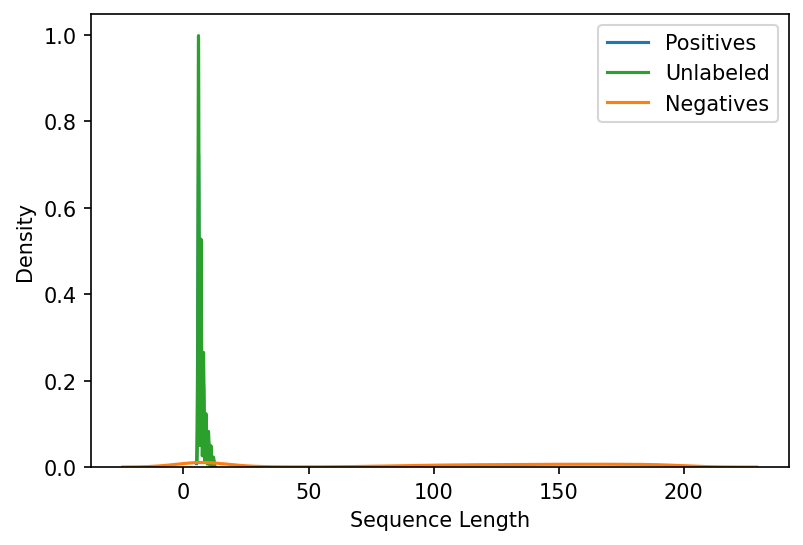

In [12]:
fig, ax = plt.subplots(dpi=150)
sns.kdeplot(pos_data_lengths, ax=ax, label='Positives', color='C0')
ax.set_xlabel('Sequence Length')
# ax.set_title(f'{peptide_label}')
sns.kdeplot(unlabeled_data_lengths, ax=ax, label='Unlabeled', color='C2')
sns.kdeplot(neg_data_lengths, ax=ax, label='Negatives', color='C1')
plt.legend()

In [13]:
def decoder(seq_vector):
  alphabet = ['A','R','N','D','C','Q','E','G','H','I', 'L','K','M','F','P','S','T','W','Y','V']
  seq = []
  for i, index in enumerate(seq_vector):
    if index == 0:
      break
    seq.append(alphabet[int(index)-1])
  seq = ''.join(seq)
  return seq
# need to decode postive and negative data to get UniRep representations
pos_sequences = []
for f in pos_data:
  pos_sequences.append(decoder(f))

neg_sequences = []
for f in neg_data:
  neg_sequences.append(decoder(f))

In [14]:
# Generating UniRep representations for postives, negatives and unlableled (This cell takes long to run)
from jax_unirep import get_reps
h_avg, h_final, c_final = get_reps(pos_sequences)
pos_UniRep = h_avg

h_avg, h_final, c_final = get_reps(neg_sequences)
neg_UniRep = h_avg

h_avg, h_final, c_final = get_reps(sampled_sequences)
unlabeled_UniRep = h_avg

/home/mgholiza/.conda/envs/covid-19/lib/python3.7/site-packages/jax/experimental/stax.py:30: FutureWarning: jax.experimental.stax is deprecated, import jax.example_libraries.stax instead
  FutureWarning)
/home/mgholiza/.conda/envs/covid-19/lib/python3.7/site-packages/jax/experimental/optimizers.py:30: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  FutureWarning)


In [19]:
# from sklearn.neighbors import LocalOutlierFactor
# from sklearn.model_selection import KFold
# from sklearn.metrics import f1_score
# from sklearn.metrics import recall_score
# kf = KFold(n_splits=5, random_state=None, shuffle=True)
# f1_scores = []
# recall_scores = []
# i = 0

# for train_index, test_index in kf.split(pos_UniRep):
#     X_train_positive_lof, X_test_positive_lof = pos_UniRep[train_index], pos_UniRep[test_index]
# #     s_train_positive_svm = np.ones(X_train_positive_svm.shape[0])
# #     s_test_positive_svm = y[train_index], y[test_index]
#     s_test_lof = np.ones(X_test_positive_lof.shape[0])
#     lof = LocalOutlierFactor(n_neighbors=64, algorithm='auto',
#                              metric='cosine', contamination=0.01,
#                              novelty=True, n_jobs=20, leaf_size=40)
#     lof.fit(X_train_positive_lof)
# #     X_validation_svm = np.concatenate([X_positive_test, X_unlabeled_test])

#     # Make prediction
#     s_pred = lof.predict(X_test_positive_lof)
#     f1 = f1_score(s_test_lof, s_pred, average='macro')
#     r = recall_score(s_test_lof, s_pred, average='macro')
#     print(f'Fold {i+1} - recall : {r:.3f}, f1 score : {f1:.3f}')
#     f1_scores.append(f1)
#     recall_scores.append(r)
#     i += 1
# #     break
# # lof_f1_score
# lof_f1_score = np.mean(f1_scores)
# lof_recall_score = np.mean(recall_scores)
# print(f'\nMean 5-Fold\n f1 score = {lof_f1_score:.3f}\n recall = {lof_recall_score:.3f}')

In [25]:
def mahalanobis_distance(x, data):
    data = np.unique(data, axis=0)
    x_minus_mu = x - np.mean(data, axis=0, keepdims=True)
    cov = np.cov(data.T)
    inv_covmat = np.linalg.pinv(cov)
    left_term = x_minus_mu @ inv_covmat
    mahal = left_term @ x_minus_mu.T
    return mahal.diagonal()
unlabeled_mahal_d = mahalanobis_distance(unlabeled_UniRep, pos_UniRep)
sorted_max_mahal_d_index = np.argsort(unlabeled_mahal_d)[::-1]
outlier_index = sorted_max_mahal_d_index[sorted_max_mahal_d_index[:100]]
initial_RNs = X_unlabeled[outlier_index]

In [26]:
# Shuffling data
shuffled_indices = np.random.permutation(len(pos_data))
X_positive = pos_data[shuffled_indices]
shuffled_indices = np.random.permutation(len(neg_data))
X_negative = neg_data[shuffled_indices]
# shuffled_indices = np.random.permutation(len(sampled_vecs))
# X_unlabeled = sampled_vecs[shuffled_indices]

In [27]:
@dataclass
class Config:
    vocab_size: int
    example_number: int
    batch_size: int
    buffer_size: int
    rnn_units: int
    hidden_dim: int
    embedding_dim: int
    reg_strength: float
    lr: float
    drop_rate: float
        
config = Config(vocab_size=21, # include gap
                example_number=len(X_positive), 
                batch_size=16, 
                buffer_size=10000,
                rnn_units=64,
                hidden_dim=64,
                embedding_dim=32,
                reg_strength=0,
                lr=1e-3,
                drop_rate=0.1
               )

def counts_aa(vec):
    counts =  tf.histogram_fixed_width(vec, [0, 20], nbins=21)[1:]
    return counts/tf.reduce_sum(counts)

def build_model(L):
    inputs = tf.keras.Input(shape=(L,))
    input_f = tf.keras.Input(shape=(20,))
    # make embedding and indicate that 0 should be treated as padding mask
    e = tf.keras.layers.Embedding(input_dim=config.vocab_size, 
                                        output_dim=config.embedding_dim,
                                        mask_zero=True)(inputs)

    # RNN layer
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(config.rnn_units, return_sequences=True))(e)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(config.rnn_units))(x)
    x = tf.keras.layers.Concatenate()([x, input_f])
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.Dropout(config.drop_rate)(x)
    # a dense hidden layer
    x = tf.keras.layers.Dense(
        config.hidden_dim, 
        activation='relu', 
        kernel_regularizer=tf.keras.regularizers.l2(config.reg_strength))(x)
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.Dropout(config.drop_rate)(x)
    x = tf.keras.layers.Dense(
        config.hidden_dim // 4, 
        activation='relu', 
        kernel_regularizer=tf.keras.regularizers.l2(config.reg_strength))(x)
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.Dropout(config.drop_rate)(x)
    # predicting prob, so no activation
    yhat = tf.keras.layers.Dense(1)(x)

    model = tf.keras.Model(inputs=[inputs, input_f], outputs=yhat, name='hemo-rnn')
    return model

In [28]:
from sklearn.model_selection import train_test_split
X_train_positive, X_test_positive, y_train_positive, y_test_positive = train_test_split(X_positive, np.ones(X_positive.shape[0]),
                                                                                        test_size=0.2, random_state=42)

In [48]:
RNs = initial_RNs
down_sampled_X_train = X_train_positive[np.random.choice(X_train_positive.shape[0], size=RNs.shape[0], replace=False)]
X_train_with_RN = np.concatenate([X_train_positive, RNs])
counts_X_train_with_RN= np.array([counts_aa(xi) for xi in X_train_with_RN])
y_train_with_RN = np.concatenate([np.ones(X_train_positive.shape[0]), np.zeros(RNs.shape[0])])
shuffler = np.random.permutation(len(X_train_with_RN))
X_train_with_RN = X_train_with_RN[shuffler]
# counts_X_train_with_RN = counts_X_train_with_RN[shuffler]
y_train_with_RN = y_train_with_RN[shuffler]
X_test = np.concatenate([X_test_positive, X_negative])
y_test = np.concatenate([np.ones(y_test_positive.shape[0]), np.zeros(X_negative.shape[0])])
# removing intial RN seeds from unlabeled
# RU = np.delete(X_unlabeled, outlier_index[0],axis=0)
RU = X_unlabeled
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.9,
                                                        patience=5, min_lr=1e-7)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_auc', patience=5, min_delta=1e-2, restore_best_weights=True)
L = None
for i in tqdm(range(50)):
    tf.keras.backend.clear_session()
    model = build_model(L)
    model.compile(
            optimizer=tf.optimizers.Adam(1e-3, clipnorm=1.0),
            loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
            metrics=[tf.keras.metrics.AUC(from_logits=True), tf.keras.metrics.BinaryAccuracy(threshold=0)],
            )
    history = model.fit(
        [X_train_with_RN, counts_X_train_with_RN] , y_train_with_RN,
        validation_data=([X_test, np.array([counts_aa(xi) for xi in X_test])] , y_test), 
        epochs=50,
        batch_size=16,
    #     batch_size=64,
    #     steps_per_epoch=100,
        # early_stopping
        callbacks=[reduce_lr, early_stopping],
        verbose=1,
    #         class_weight=class_weights
    )
    prob = model.predict([RU, np.array([counts_aa(xi) for xi in RU])])
    V = RU[np.argsort(prob[:,0])] 
#     break
#     print(f'Negatives found: {V.shape[0]}')
#     if V.shape[0] == 0:
#         print('All unlabeled were predicted as positive')
#         RNs = outlier_values
#         break
    # print(V.shape)
#     else:
        # print(RNs.shape)
#         n_downsample = V.shape[0] - X_train_positive_svm.shape[0]
#         print(RNs.shape) 
    if i == 0:
        RNs = np.empty(shape=(0, 200))

#     RNs = np.concatenate([RNs, V[:20*(i+1)]])
    RNs = V[:80*(i+1)]
#         RU = RU[:][np.squeeze(prob > 0.001)]
#     RU = np.delete(RU, np.argsort(prob[:,0])[:20*(i+1)], axis=0)
    print(f'Reliable negative size: {RNs.shape[0]}   Unlabeled size: {RU.shape[0]}')
    if RU.shape[0] == 0:
        print('All unlabeled were predicted as negative')
        break
    if RNs.shape[0] > X_train_positive.shape[0]:
        print('RNs size exceeded positives size')
        break
#         RNs = equalizer(X_train_positive_lof, RNs)
    down_sampled_X_train = X_train_positive[np.random.choice(X_train_positive.shape[0], size=RNs.shape[0], replace=False)]
    print(f'pos size: {down_sampled_X_train.shape[0]} RN size: {RNs.shape[0]}')
    X_train_with_RN = np.concatenate([X_train_positive, RNs])
    counts_X_train_with_RN = np.array([counts_aa(xi) for xi in X_train_with_RN])
    y_train_with_RN = np.concatenate([np.ones(X_train_positive.shape[0]), np.zeros(RNs.shape[0])])
    shuffler = np.random.permutation(len(X_train_with_RN))
    X_train_with_RN = X_train_with_RN[shuffler]
    counts_X_train_with_RN = counts_X_train_with_RN[shuffler]
    y_train_with_RN = y_train_with_RN[shuffler]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50
187/187 [==============================] - 25s 89ms/step - loss: 0.1663 - auc: 0.4641 - binary_accuracy: 0.9624 - val_loss: 3.0630 - val_auc: 0.8739 - val_binary_accuracy: 0.0503
Epoch 2/50
187/187 [==============================] - 13s 71ms/step - loss: 0.1259 - auc: 0.7726 - binary_accuracy: 0.9658 - val_loss: 2.8677 - val_auc: 0.6824 - val_binary_accuracy: 0.3497
Epoch 3/50
187/187 [==============================] - 13s 71ms/step - loss: 0.0975 - auc: 0.8669 - binary_accuracy: 0.9708 - val_loss: 3.5010 - val_auc: 0.8060 - val_binary_accuracy: 0.0619
Epoch 4/50
187/187 [==============================] - 13s 71ms/step - loss: 0.0827 - auc: 0.9124 - binary_accuracy: 0.9742 - val_loss: 3.1763 - val_auc: 0.7507 - val_binary_accuracy: 0.0656
Epoch 5/50
187/187 [==============================] - 13s 71ms/step - loss: 0.0727 - auc: 0.9341 - binary_accuracy: 0.9779 - val_loss: 3.4846 - val_auc: 0.8166 - val_binary_accuracy: 0.0638
Epoch 6/50
187/187 [==============================

  2%|▏         | 1/50 [02:10<1:46:17, 130.15s/it]

Epoch 1/50
185/185 [==============================] - 23s 81ms/step - loss: 0.0689 - auc: 0.9397 - binary_accuracy: 0.9770 - val_loss: 4.9458 - val_auc: 0.5601 - val_binary_accuracy: 0.1616
Epoch 2/50
185/185 [==============================] - 13s 68ms/step - loss: 0.0219 - auc: 0.9841 - binary_accuracy: 0.9936 - val_loss: 4.9513 - val_auc: 0.6877 - val_binary_accuracy: 0.0977
Epoch 3/50
185/185 [==============================] - 13s 68ms/step - loss: 0.0084 - auc: 0.9930 - binary_accuracy: 0.9980 - val_loss: 4.6333 - val_auc: 0.6634 - val_binary_accuracy: 0.2157
Epoch 4/50
185/185 [==============================] - 13s 68ms/step - loss: 0.0024 - auc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 5.6420 - val_auc: 0.5746 - val_binary_accuracy: 0.1911
Epoch 5/50
185/185 [==============================] - 12s 68ms/step - loss: 0.0013 - auc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 5.5351 - val_auc: 0.5994 - val_binary_accuracy: 0.2396
Epoch 6/50
185/185 [==============================

  4%|▍         | 2/50 [04:01<1:39:32, 124.44s/it]

Epoch 1/50
190/190 [==============================] - 23s 80ms/step - loss: 0.0448 - auc: 0.9962 - binary_accuracy: 0.9862 - val_loss: 4.6279 - val_auc: 0.5902 - val_binary_accuracy: 0.2042
Epoch 2/50
190/190 [==============================] - 12s 66ms/step - loss: 0.0102 - auc: 0.9996 - binary_accuracy: 0.9984 - val_loss: 1.7613 - val_auc: 0.8688 - val_binary_accuracy: 0.6952
Epoch 3/50
190/190 [==============================] - 13s 66ms/step - loss: 0.0116 - auc: 0.9996 - binary_accuracy: 0.9964 - val_loss: 3.7326 - val_auc: 0.7386 - val_binary_accuracy: 0.3876
Epoch 4/50
190/190 [==============================] - 12s 66ms/step - loss: 0.0020 - auc: 1.0000 - binary_accuracy: 0.9997 - val_loss: 5.7822 - val_auc: 0.6228 - val_binary_accuracy: 0.0898
Epoch 5/50
190/190 [==============================] - 12s 65ms/step - loss: 0.0018 - auc: 1.0000 - binary_accuracy: 0.9997 - val_loss: 4.1241 - val_auc: 0.7286 - val_binary_accuracy: 0.4128
Epoch 6/50
190/190 [==============================

  6%|▌         | 3/50 [07:44<2:00:48, 154.23s/it]

Epoch 1/50
195/195 [==============================] - 23s 78ms/step - loss: 0.0500 - auc: 0.9954 - binary_accuracy: 0.9856 - val_loss: 4.7149 - val_auc: 0.5770 - val_binary_accuracy: 0.1955
Epoch 2/50
195/195 [==============================] - 12s 63ms/step - loss: 0.0082 - auc: 0.9999 - binary_accuracy: 0.9978 - val_loss: 4.2365 - val_auc: 0.6674 - val_binary_accuracy: 0.3511
Epoch 3/50
195/195 [==============================] - 12s 64ms/step - loss: 0.0067 - auc: 0.9998 - binary_accuracy: 0.9984 - val_loss: 4.3408 - val_auc: 0.6739 - val_binary_accuracy: 0.3819
Epoch 4/50
195/195 [==============================] - 12s 64ms/step - loss: 0.0052 - auc: 1.0000 - binary_accuracy: 0.9984 - val_loss: 6.1375 - val_auc: 0.5870 - val_binary_accuracy: 0.0614
Epoch 5/50
195/195 [==============================] - 13s 66ms/step - loss: 0.0011 - auc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 6.5302 - val_auc: 0.5820 - val_binary_accuracy: 0.0535
Epoch 6/50
195/195 [==============================

  8%|▊         | 4/50 [09:36<1:48:19, 141.30s/it]

Epoch 1/50
200/200 [==============================] - 22s 76ms/step - loss: 0.0584 - auc: 0.9949 - binary_accuracy: 0.9787 - val_loss: 5.7081 - val_auc: 0.5029 - val_binary_accuracy: 0.0563
Epoch 2/50
200/200 [==============================] - 12s 63ms/step - loss: 0.0053 - auc: 1.0000 - binary_accuracy: 0.9994 - val_loss: 5.5225 - val_auc: 0.5560 - val_binary_accuracy: 0.1519
Epoch 3/50
200/200 [==============================] - 13s 64ms/step - loss: 0.0098 - auc: 0.9982 - binary_accuracy: 0.9978 - val_loss: 5.4747 - val_auc: 0.5834 - val_binary_accuracy: 0.2108
Epoch 4/50
200/200 [==============================] - 13s 64ms/step - loss: 0.0065 - auc: 0.9984 - binary_accuracy: 0.9987 - val_loss: 6.5361 - val_auc: 0.5310 - val_binary_accuracy: 0.0549
Epoch 5/50
200/200 [==============================] - 12s 62ms/step - loss: 0.0012 - auc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 6.9780 - val_auc: 0.5258 - val_binary_accuracy: 0.0593
Epoch 6/50
200/200 [==============================

 10%|█         | 5/50 [11:29<1:39:41, 132.93s/it]

Epoch 1/50
205/205 [==============================] - 23s 77ms/step - loss: 0.0604 - auc: 0.9978 - binary_accuracy: 0.9838 - val_loss: 4.8345 - val_auc: 0.5589 - val_binary_accuracy: 0.0750
Epoch 2/50
205/205 [==============================] - 13s 62ms/step - loss: 0.0159 - auc: 0.9995 - binary_accuracy: 0.9970 - val_loss: 3.3462 - val_auc: 0.7470 - val_binary_accuracy: 0.3878
Epoch 3/50
205/205 [==============================] - 13s 62ms/step - loss: 0.0048 - auc: 1.0000 - binary_accuracy: 0.9997 - val_loss: 5.9243 - val_auc: 0.5564 - val_binary_accuracy: 0.0863
Epoch 4/50
205/205 [==============================] - 13s 63ms/step - loss: 0.0082 - auc: 0.9997 - binary_accuracy: 0.9979 - val_loss: 4.3404 - val_auc: 0.7047 - val_binary_accuracy: 0.3171
Epoch 5/50
205/205 [==============================] - 13s 62ms/step - loss: 0.0013 - auc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 4.5672 - val_auc: 0.7021 - val_binary_accuracy: 0.3271
Epoch 6/50
205/205 [==============================

 12%|█▏        | 6/50 [13:24<1:33:29, 127.48s/it]

Epoch 1/50
210/210 [==============================] - 21s 72ms/step - loss: 0.0837 - auc: 0.9906 - binary_accuracy: 0.9732 - val_loss: 4.3807 - val_auc: 0.5165 - val_binary_accuracy: 0.1721
Epoch 2/50
210/210 [==============================] - 13s 61ms/step - loss: 0.0306 - auc: 0.9987 - binary_accuracy: 0.9911 - val_loss: 4.8152 - val_auc: 0.5820 - val_binary_accuracy: 0.1865
Epoch 3/50
210/210 [==============================] - 12s 60ms/step - loss: 0.0261 - auc: 0.9981 - binary_accuracy: 0.9908 - val_loss: 4.4404 - val_auc: 0.7452 - val_binary_accuracy: 0.1055
Epoch 4/50
210/210 [==============================] - 12s 59ms/step - loss: 0.0188 - auc: 0.9996 - binary_accuracy: 0.9946 - val_loss: 5.1418 - val_auc: 0.6266 - val_binary_accuracy: 0.1056
Epoch 5/50
210/210 [==============================] - 13s 60ms/step - loss: 0.0221 - auc: 0.9993 - binary_accuracy: 0.9920 - val_loss: 4.6315 - val_auc: 0.6937 - val_binary_accuracy: 0.1898
Epoch 6/50
210/210 [==============================

 14%|█▍        | 7/50 [15:17<1:28:11, 123.05s/it]

Epoch 1/50
215/215 [==============================] - 22s 73ms/step - loss: 0.0649 - auc: 0.9958 - binary_accuracy: 0.9773 - val_loss: 5.3735 - val_auc: 0.4991 - val_binary_accuracy: 0.0659
Epoch 2/50
215/215 [==============================] - 13s 59ms/step - loss: 0.0098 - auc: 1.0000 - binary_accuracy: 0.9977 - val_loss: 6.0827 - val_auc: 0.5022 - val_binary_accuracy: 0.0545
Epoch 3/50
215/215 [==============================] - 13s 59ms/step - loss: 0.0077 - auc: 0.9997 - binary_accuracy: 0.9985 - val_loss: 6.5564 - val_auc: 0.5008 - val_binary_accuracy: 0.0548
Epoch 4/50
215/215 [==============================] - 13s 60ms/step - loss: 0.0019 - auc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 6.9710 - val_auc: 0.5031 - val_binary_accuracy: 0.0580
Epoch 5/50
215/215 [==============================] - 13s 59ms/step - loss: 0.0071 - auc: 0.9999 - binary_accuracy: 0.9985 - val_loss: 6.3622 - val_auc: 0.5063 - val_binary_accuracy: 0.0578
Epoch 6/50
215/215 [==============================

 16%|█▌        | 8/50 [17:11<1:24:18, 120.43s/it]

Epoch 1/50
220/220 [==============================] - 21s 69ms/step - loss: 0.0848 - auc: 0.9933 - binary_accuracy: 0.9705 - val_loss: 5.1073 - val_auc: 0.5000 - val_binary_accuracy: 0.0566
Epoch 2/50
220/220 [==============================] - 13s 57ms/step - loss: 0.0227 - auc: 0.9974 - binary_accuracy: 0.9946 - val_loss: 3.8239 - val_auc: 0.7133 - val_binary_accuracy: 0.2922
Epoch 3/50
220/220 [==============================] - 13s 58ms/step - loss: 0.0144 - auc: 0.9997 - binary_accuracy: 0.9972 - val_loss: 5.1290 - val_auc: 0.6056 - val_binary_accuracy: 0.1708
Epoch 4/50
220/220 [==============================] - 13s 59ms/step - loss: 0.0131 - auc: 0.9993 - binary_accuracy: 0.9974 - val_loss: 2.8189 - val_auc: 0.7912 - val_binary_accuracy: 0.5736
Epoch 5/50
220/220 [==============================] - 13s 58ms/step - loss: 0.0180 - auc: 0.9993 - binary_accuracy: 0.9946 - val_loss: 3.0671 - val_auc: 0.8105 - val_binary_accuracy: 0.4584
Epoch 6/50
220/220 [==============================

 18%|█▊        | 9/50 [19:02<1:20:25, 117.69s/it]

Epoch 1/50
225/225 [==============================] - 23s 73ms/step - loss: 0.0649 - auc: 0.9973 - binary_accuracy: 0.9756 - val_loss: 5.5499 - val_auc: 0.5094 - val_binary_accuracy: 0.0717
Epoch 2/50
225/225 [==============================] - 13s 56ms/step - loss: 0.0198 - auc: 0.9964 - binary_accuracy: 0.9961 - val_loss: 5.9276 - val_auc: 0.5031 - val_binary_accuracy: 0.0534
Epoch 3/50
225/225 [==============================] - 13s 56ms/step - loss: 0.0052 - auc: 0.9998 - binary_accuracy: 0.9994 - val_loss: 6.4731 - val_auc: 0.5013 - val_binary_accuracy: 0.0532
Epoch 4/50
225/225 [==============================] - 13s 56ms/step - loss: 0.0074 - auc: 0.9991 - binary_accuracy: 0.9986 - val_loss: 5.8425 - val_auc: 0.5789 - val_binary_accuracy: 0.1467
Epoch 5/50
225/225 [==============================] - 13s 56ms/step - loss: 0.0030 - auc: 1.0000 - binary_accuracy: 0.9997 - val_loss: 7.2729 - val_auc: 0.5022 - val_binary_accuracy: 0.0527
Epoch 6/50
225/225 [==============================

 20%|██        | 10/50 [20:54<1:17:13, 115.85s/it]

Epoch 1/50
230/230 [==============================] - 24s 75ms/step - loss: 0.0679 - auc: 0.9966 - binary_accuracy: 0.9726 - val_loss: 5.7250 - val_auc: 0.4993 - val_binary_accuracy: 0.0527
Epoch 2/50
230/230 [==============================] - 13s 56ms/step - loss: 0.0057 - auc: 0.9997 - binary_accuracy: 0.9997 - val_loss: 6.2465 - val_auc: 0.4995 - val_binary_accuracy: 0.0552
Epoch 3/50
230/230 [==============================] - 13s 56ms/step - loss: 0.0070 - auc: 0.9999 - binary_accuracy: 0.9986 - val_loss: 6.5064 - val_auc: 0.5054 - val_binary_accuracy: 0.0682
Epoch 4/50
230/230 [==============================] - 13s 56ms/step - loss: 0.0112 - auc: 0.9989 - binary_accuracy: 0.9978 - val_loss: 6.8396 - val_auc: 0.5017 - val_binary_accuracy: 0.0548
Epoch 5/50
230/230 [==============================] - 13s 56ms/step - loss: 0.0044 - auc: 1.0000 - binary_accuracy: 0.9992 - val_loss: 7.1796 - val_auc: 0.5025 - val_binary_accuracy: 0.0566
Epoch 6/50
230/230 [==============================

 22%|██▏       | 11/50 [22:48<1:14:58, 115.36s/it]

Epoch 1/50
235/235 [==============================] - 23s 72ms/step - loss: 0.0593 - auc: 0.9980 - binary_accuracy: 0.9782 - val_loss: 5.4765 - val_auc: 0.5008 - val_binary_accuracy: 0.0539
Epoch 2/50
235/235 [==============================] - 13s 55ms/step - loss: 0.0098 - auc: 1.0000 - binary_accuracy: 0.9981 - val_loss: 6.1147 - val_auc: 0.5020 - val_binary_accuracy: 0.0556
Epoch 3/50
235/235 [==============================] - 13s 54ms/step - loss: 0.0029 - auc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 6.5481 - val_auc: 0.5096 - val_binary_accuracy: 0.0783
Epoch 4/50
235/235 [==============================] - 13s 54ms/step - loss: 0.0225 - auc: 0.9978 - binary_accuracy: 0.9957 - val_loss: 6.6241 - val_auc: 0.5016 - val_binary_accuracy: 0.0697
Epoch 5/50
235/235 [==============================] - 13s 55ms/step - loss: 0.0167 - auc: 0.9984 - binary_accuracy: 0.9965 - val_loss: 6.6999 - val_auc: 0.5069 - val_binary_accuracy: 0.0597
Epoch 6/50
235/235 [==============================

 24%|██▍       | 12/50 [24:41<1:12:38, 114.70s/it]

Epoch 1/50
240/240 [==============================] - 23s 72ms/step - loss: 0.0823 - auc: 0.9977 - binary_accuracy: 0.9805 - val_loss: 3.5750 - val_auc: 0.6247 - val_binary_accuracy: 0.0786
Epoch 2/50
240/240 [==============================] - 13s 54ms/step - loss: 0.0163 - auc: 0.9989 - binary_accuracy: 0.9971 - val_loss: 5.2657 - val_auc: 0.5097 - val_binary_accuracy: 0.0719
Epoch 3/50
240/240 [==============================] - 13s 53ms/step - loss: 0.0136 - auc: 0.9998 - binary_accuracy: 0.9974 - val_loss: 6.0783 - val_auc: 0.5021 - val_binary_accuracy: 0.0579
Epoch 4/50
240/240 [==============================] - 13s 54ms/step - loss: 0.0069 - auc: 0.9999 - binary_accuracy: 0.9990 - val_loss: 6.5786 - val_auc: 0.5042 - val_binary_accuracy: 0.0624
Epoch 5/50
240/240 [==============================] - 13s 54ms/step - loss: 0.0092 - auc: 0.9992 - binary_accuracy: 0.9984 - val_loss: 6.7626 - val_auc: 0.5080 - val_binary_accuracy: 0.0687
Epoch 6/50
240/240 [==============================

 26%|██▌       | 13/50 [26:48<1:12:57, 118.30s/it]

Epoch 1/50
245/245 [==============================] - 24s 73ms/step - loss: 0.0650 - auc: 0.9967 - binary_accuracy: 0.9753 - val_loss: 6.0677 - val_auc: 0.5098 - val_binary_accuracy: 0.0558
Epoch 2/50
245/245 [==============================] - 13s 52ms/step - loss: 0.0110 - auc: 0.9997 - binary_accuracy: 0.9972 - val_loss: 6.2796 - val_auc: 0.5178 - val_binary_accuracy: 0.0786
Epoch 3/50
245/245 [==============================] - 13s 53ms/step - loss: 0.0096 - auc: 0.9999 - binary_accuracy: 0.9977 - val_loss: 5.6269 - val_auc: 0.5885 - val_binary_accuracy: 0.1744
Epoch 4/50
245/245 [==============================] - 13s 53ms/step - loss: 0.0140 - auc: 0.9982 - binary_accuracy: 0.9972 - val_loss: 6.6341 - val_auc: 0.5141 - val_binary_accuracy: 0.0781
Epoch 5/50
245/245 [==============================] - 13s 53ms/step - loss: 0.0104 - auc: 0.9996 - binary_accuracy: 0.9974 - val_loss: 6.1080 - val_auc: 0.5727 - val_binary_accuracy: 0.1828
Epoch 6/50
245/245 [==============================

 28%|██▊       | 14/50 [28:43<1:10:24, 117.34s/it]

Epoch 1/50
250/250 [==============================] - 24s 63ms/step - loss: 0.0627 - auc: 0.9971 - binary_accuracy: 0.9785 - val_loss: 4.8691 - val_auc: 0.6438 - val_binary_accuracy: 0.0720
Epoch 2/50
250/250 [==============================] - 13s 52ms/step - loss: 0.0133 - auc: 0.9998 - binary_accuracy: 0.9967 - val_loss: 3.2553 - val_auc: 0.8533 - val_binary_accuracy: 0.2739
Epoch 3/50
250/250 [==============================] - 13s 52ms/step - loss: 0.0056 - auc: 1.0000 - binary_accuracy: 0.9990 - val_loss: 6.1226 - val_auc: 0.5329 - val_binary_accuracy: 0.0649
Epoch 4/50
250/250 [==============================] - 13s 52ms/step - loss: 0.0094 - auc: 0.9995 - binary_accuracy: 0.9975 - val_loss: 4.7191 - val_auc: 0.6488 - val_binary_accuracy: 0.2583
Epoch 5/50
250/250 [==============================] - 13s 52ms/step - loss: 0.0050 - auc: 1.0000 - binary_accuracy: 0.9987 - val_loss: 6.1826 - val_auc: 0.5423 - val_binary_accuracy: 0.0903
Epoch 6/50
250/250 [==============================

 30%|███       | 15/50 [31:04<1:12:34, 124.41s/it]

Epoch 1/50
255/255 [==============================] - 23s 62ms/step - loss: 0.0566 - auc: 0.9983 - binary_accuracy: 0.9833 - val_loss: 5.0092 - val_auc: 0.5512 - val_binary_accuracy: 0.1009
Epoch 2/50
255/255 [==============================] - 13s 52ms/step - loss: 0.0158 - auc: 0.9991 - binary_accuracy: 0.9968 - val_loss: 6.0163 - val_auc: 0.5070 - val_binary_accuracy: 0.0549
Epoch 3/50
255/255 [==============================] - 13s 51ms/step - loss: 0.0149 - auc: 0.9994 - binary_accuracy: 0.9966 - val_loss: 3.4087 - val_auc: 0.7823 - val_binary_accuracy: 0.3683
Epoch 4/50
255/255 [==============================] - 14s 54ms/step - loss: 0.0072 - auc: 1.0000 - binary_accuracy: 0.9983 - val_loss: 5.3659 - val_auc: 0.6644 - val_binary_accuracy: 0.1203
Epoch 5/50
255/255 [==============================] - 13s 53ms/step - loss: 0.0032 - auc: 0.9998 - binary_accuracy: 0.9998 - val_loss: 5.6454 - val_auc: 0.6208 - val_binary_accuracy: 0.1674
Epoch 6/50
255/255 [==============================

 32%|███▏      | 16/50 [33:15<1:11:37, 126.40s/it]

Epoch 1/50
260/260 [==============================] - 24s 62ms/step - loss: 0.0569 - auc: 0.9981 - binary_accuracy: 0.9805 - val_loss: 5.4089 - val_auc: 0.4993 - val_binary_accuracy: 0.0567
Epoch 2/50
260/260 [==============================] - 13s 52ms/step - loss: 0.0129 - auc: 0.9988 - binary_accuracy: 0.9974 - val_loss: 5.6851 - val_auc: 0.5163 - val_binary_accuracy: 0.0576
Epoch 3/50
260/260 [==============================] - 13s 52ms/step - loss: 0.0059 - auc: 0.9996 - binary_accuracy: 0.9993 - val_loss: 5.8828 - val_auc: 0.5536 - val_binary_accuracy: 0.1150
Epoch 4/50
260/260 [==============================] - 14s 52ms/step - loss: 0.0126 - auc: 0.9996 - binary_accuracy: 0.9966 - val_loss: 5.0722 - val_auc: 0.6657 - val_binary_accuracy: 0.1441
Epoch 5/50
260/260 [==============================] - 14s 53ms/step - loss: 0.0042 - auc: 0.9998 - binary_accuracy: 0.9993 - val_loss: 6.9896 - val_auc: 0.5271 - val_binary_accuracy: 0.0842
Epoch 6/50
260/260 [==============================

 34%|███▍      | 17/50 [35:16<1:08:36, 124.75s/it]

Epoch 1/50
265/265 [==============================] - 24s 61ms/step - loss: 0.0412 - auc: 0.9990 - binary_accuracy: 0.9880 - val_loss: 5.7591 - val_auc: 0.5044 - val_binary_accuracy: 0.0610
Epoch 2/50
265/265 [==============================] - 13s 50ms/step - loss: 0.0121 - auc: 0.9999 - binary_accuracy: 0.9974 - val_loss: 6.3579 - val_auc: 0.5173 - val_binary_accuracy: 0.0618
Epoch 3/50
265/265 [==============================] - 13s 51ms/step - loss: 0.0049 - auc: 0.9998 - binary_accuracy: 0.9991 - val_loss: 7.0112 - val_auc: 0.5154 - val_binary_accuracy: 0.0675
Epoch 4/50
265/265 [==============================] - 13s 50ms/step - loss: 0.0128 - auc: 0.9995 - binary_accuracy: 0.9962 - val_loss: 7.1378 - val_auc: 0.5107 - val_binary_accuracy: 0.0668
Epoch 5/50
265/265 [==============================] - 13s 51ms/step - loss: 0.0071 - auc: 0.9994 - binary_accuracy: 0.9979 - val_loss: 7.3539 - val_auc: 0.5134 - val_binary_accuracy: 0.0710
Epoch 6/50
265/265 [==============================

 36%|███▌      | 18/50 [37:16<1:05:46, 123.32s/it]

Epoch 1/50
270/270 [==============================] - 23s 60ms/step - loss: 0.0744 - auc: 0.9968 - binary_accuracy: 0.9729 - val_loss: 4.7521 - val_auc: 0.5501 - val_binary_accuracy: 0.1466
Epoch 2/50
270/270 [==============================] - 14s 50ms/step - loss: 0.0179 - auc: 0.9993 - binary_accuracy: 0.9961 - val_loss: 5.6738 - val_auc: 0.5277 - val_binary_accuracy: 0.0872
Epoch 3/50
270/270 [==============================] - 14s 51ms/step - loss: 0.0127 - auc: 0.9994 - binary_accuracy: 0.9968 - val_loss: 4.2563 - val_auc: 0.6732 - val_binary_accuracy: 0.3357
Epoch 4/50
270/270 [==============================] - 14s 51ms/step - loss: 0.0143 - auc: 0.9993 - binary_accuracy: 0.9963 - val_loss: 4.9351 - val_auc: 0.6340 - val_binary_accuracy: 0.2725
Epoch 5/50
270/270 [==============================] - 14s 51ms/step - loss: 0.0089 - auc: 0.9998 - binary_accuracy: 0.9972 - val_loss: 4.1200 - val_auc: 0.7062 - val_binary_accuracy: 0.3913
Epoch 6/50
270/270 [==============================

 38%|███▊      | 19/50 [39:31<1:05:33, 126.87s/it]

Epoch 1/50
275/275 [==============================] - 22s 59ms/step - loss: 0.0510 - auc: 0.9981 - binary_accuracy: 0.9823 - val_loss: 5.3655 - val_auc: 0.5418 - val_binary_accuracy: 0.0787
Epoch 2/50
275/275 [==============================] - 13s 49ms/step - loss: 0.0099 - auc: 0.9999 - binary_accuracy: 0.9980 - val_loss: 6.1553 - val_auc: 0.5281 - val_binary_accuracy: 0.0737
Epoch 3/50
275/275 [==============================] - 14s 50ms/step - loss: 0.0146 - auc: 0.9991 - binary_accuracy: 0.9959 - val_loss: 5.6408 - val_auc: 0.6008 - val_binary_accuracy: 0.1570
Epoch 4/50
275/275 [==============================] - 14s 50ms/step - loss: 0.0055 - auc: 0.9998 - binary_accuracy: 0.9993 - val_loss: 6.4595 - val_auc: 0.5596 - val_binary_accuracy: 0.1293
Epoch 5/50
275/275 [==============================] - 13s 49ms/step - loss: 0.0056 - auc: 0.9997 - binary_accuracy: 0.9986 - val_loss: 6.7536 - val_auc: 0.5309 - val_binary_accuracy: 0.0679
Epoch 6/50
275/275 [==============================

 40%|████      | 20/50 [41:43<1:04:12, 128.41s/it]

Epoch 1/50
280/280 [==============================] - 23s 58ms/step - loss: 0.0630 - auc: 0.9979 - binary_accuracy: 0.9808 - val_loss: 5.2340 - val_auc: 0.5206 - val_binary_accuracy: 0.0909
Epoch 2/50
280/280 [==============================] - 14s 49ms/step - loss: 0.0175 - auc: 0.9994 - binary_accuracy: 0.9964 - val_loss: 6.0312 - val_auc: 0.5041 - val_binary_accuracy: 0.0544
Epoch 3/50
280/280 [==============================] - 14s 49ms/step - loss: 0.0091 - auc: 0.9998 - binary_accuracy: 0.9982 - val_loss: 6.1814 - val_auc: 0.5277 - val_binary_accuracy: 0.0960
Epoch 4/50
280/280 [==============================] - 14s 48ms/step - loss: 0.0047 - auc: 0.9996 - binary_accuracy: 0.9991 - val_loss: 6.0263 - val_auc: 0.5672 - val_binary_accuracy: 0.1846
Epoch 5/50
280/280 [==============================] - 14s 49ms/step - loss: 0.0079 - auc: 0.9995 - binary_accuracy: 0.9973 - val_loss: 4.0150 - val_auc: 0.7206 - val_binary_accuracy: 0.4654
Epoch 6/50
280/280 [==============================

 42%|████▏     | 21/50 [43:55<1:02:36, 129.55s/it]

Epoch 1/50
285/285 [==============================] - 23s 57ms/step - loss: 0.0670 - auc: 0.9973 - binary_accuracy: 0.9761 - val_loss: 5.4706 - val_auc: 0.5009 - val_binary_accuracy: 0.0546
Epoch 2/50
285/285 [==============================] - 14s 48ms/step - loss: 0.0141 - auc: 0.9996 - binary_accuracy: 0.9969 - val_loss: 5.9534 - val_auc: 0.5107 - val_binary_accuracy: 0.0757
Epoch 3/50
285/285 [==============================] - 14s 48ms/step - loss: 0.0072 - auc: 1.0000 - binary_accuracy: 0.9982 - val_loss: 6.4206 - val_auc: 0.5139 - val_binary_accuracy: 0.0765
Epoch 4/50
285/285 [==============================] - 14s 49ms/step - loss: 0.0128 - auc: 0.9992 - binary_accuracy: 0.9969 - val_loss: 6.6224 - val_auc: 0.5163 - val_binary_accuracy: 0.0746
Epoch 5/50
285/285 [==============================] - 14s 48ms/step - loss: 0.0047 - auc: 1.0000 - binary_accuracy: 0.9987 - val_loss: 7.1898 - val_auc: 0.5031 - val_binary_accuracy: 0.0547
Epoch 6/50
285/285 [==============================

 44%|████▍     | 22/50 [45:53<58:53, 126.21s/it]  

Epoch 1/50
290/290 [==============================] - 24s 57ms/step - loss: 0.0598 - auc: 0.9974 - binary_accuracy: 0.9812 - val_loss: 5.4116 - val_auc: 0.4938 - val_binary_accuracy: 0.0582
Epoch 2/50
290/290 [==============================] - 14s 47ms/step - loss: 0.0078 - auc: 1.0000 - binary_accuracy: 0.9987 - val_loss: 5.9055 - val_auc: 0.5320 - val_binary_accuracy: 0.1114
Epoch 3/50
290/290 [==============================] - 14s 47ms/step - loss: 0.0130 - auc: 0.9995 - binary_accuracy: 0.9972 - val_loss: 6.3739 - val_auc: 0.5129 - val_binary_accuracy: 0.0814
Epoch 4/50
290/290 [==============================] - 14s 47ms/step - loss: 0.0067 - auc: 0.9996 - binary_accuracy: 0.9989 - val_loss: 6.0202 - val_auc: 0.5668 - val_binary_accuracy: 0.1770
Epoch 5/50
290/290 [==============================] - 13s 46ms/step - loss: 0.0144 - auc: 0.9991 - binary_accuracy: 0.9961 - val_loss: 4.9026 - val_auc: 0.6550 - val_binary_accuracy: 0.2765
Epoch 6/50
290/290 [==============================

 46%|████▌     | 23/50 [47:52<55:42, 123.80s/it]

Epoch 1/50
295/295 [==============================] - 23s 55ms/step - loss: 0.0653 - auc: 0.9975 - binary_accuracy: 0.9778 - val_loss: 5.3796 - val_auc: 0.5044 - val_binary_accuracy: 0.0811
Epoch 2/50
295/295 [==============================] - 13s 46ms/step - loss: 0.0204 - auc: 0.9989 - binary_accuracy: 0.9958 - val_loss: 6.1431 - val_auc: 0.5007 - val_binary_accuracy: 0.0539
Epoch 3/50
295/295 [==============================] - 13s 46ms/step - loss: 0.0161 - auc: 0.9996 - binary_accuracy: 0.9960 - val_loss: 6.3412 - val_auc: 0.5103 - val_binary_accuracy: 0.0802
Epoch 4/50
295/295 [==============================] - 13s 45ms/step - loss: 0.0099 - auc: 0.9997 - binary_accuracy: 0.9975 - val_loss: 6.8412 - val_auc: 0.5061 - val_binary_accuracy: 0.0670
Epoch 5/50
295/295 [==============================] - 13s 46ms/step - loss: 0.0116 - auc: 0.9993 - binary_accuracy: 0.9970 - val_loss: 7.0990 - val_auc: 0.5007 - val_binary_accuracy: 0.0544
Epoch 6/50
295/295 [==============================

 48%|████▊     | 24/50 [49:49<52:48, 121.86s/it]

Epoch 1/50
300/300 [==============================] - 23s 54ms/step - loss: 0.0524 - auc: 0.9979 - binary_accuracy: 0.9821 - val_loss: 5.9861 - val_auc: 0.5138 - val_binary_accuracy: 0.0788
Epoch 2/50
300/300 [==============================] - 14s 45ms/step - loss: 0.0186 - auc: 0.9996 - binary_accuracy: 0.9950 - val_loss: 5.0848 - val_auc: 0.6015 - val_binary_accuracy: 0.2531
Epoch 3/50
300/300 [==============================] - 14s 46ms/step - loss: 0.0218 - auc: 0.9992 - binary_accuracy: 0.9946 - val_loss: 6.2651 - val_auc: 0.5447 - val_binary_accuracy: 0.1288
Epoch 4/50
300/300 [==============================] - 14s 45ms/step - loss: 0.0191 - auc: 0.9994 - binary_accuracy: 0.9942 - val_loss: 2.3099 - val_auc: 0.8342 - val_binary_accuracy: 0.6841
Epoch 5/50
300/300 [==============================] - 14s 45ms/step - loss: 0.0145 - auc: 0.9991 - binary_accuracy: 0.9969 - val_loss: 6.4079 - val_auc: 0.5455 - val_binary_accuracy: 0.1416
Epoch 6/50
300/300 [==============================

 50%|█████     | 25/50 [51:47<50:16, 120.67s/it]

Epoch 1/50
305/305 [==============================] - 23s 54ms/step - loss: 0.0426 - auc: 0.9988 - binary_accuracy: 0.9873 - val_loss: 3.9546 - val_auc: 0.7234 - val_binary_accuracy: 0.2108
Epoch 2/50
305/305 [==============================] - 14s 45ms/step - loss: 0.0204 - auc: 0.9993 - binary_accuracy: 0.9953 - val_loss: 4.2481 - val_auc: 0.7642 - val_binary_accuracy: 0.0966
Epoch 3/50
305/305 [==============================] - 14s 46ms/step - loss: 0.0077 - auc: 0.9995 - binary_accuracy: 0.9988 - val_loss: 3.9587 - val_auc: 0.7635 - val_binary_accuracy: 0.2477
Epoch 4/50
305/305 [==============================] - 14s 45ms/step - loss: 0.0088 - auc: 0.9994 - binary_accuracy: 0.9984 - val_loss: 3.7558 - val_auc: 0.7359 - val_binary_accuracy: 0.4559
Epoch 5/50
305/305 [==============================] - 14s 45ms/step - loss: 0.0070 - auc: 0.9994 - binary_accuracy: 0.9988 - val_loss: 6.4637 - val_auc: 0.5611 - val_binary_accuracy: 0.1386
Epoch 6/50
305/305 [==============================

 52%|█████▏    | 26/50 [54:43<54:51, 137.17s/it]

Epoch 1/50
310/310 [==============================] - 22s 53ms/step - loss: 0.0564 - auc: 0.9980 - binary_accuracy: 0.9815 - val_loss: 5.2940 - val_auc: 0.5715 - val_binary_accuracy: 0.1045
Epoch 2/50
310/310 [==============================] - 14s 44ms/step - loss: 0.0146 - auc: 0.9994 - binary_accuracy: 0.9968 - val_loss: 1.6802 - val_auc: 0.8722 - val_binary_accuracy: 0.7307
Epoch 3/50
310/310 [==============================] - 13s 43ms/step - loss: 0.0128 - auc: 0.9995 - binary_accuracy: 0.9968 - val_loss: 1.9944 - val_auc: 0.8532 - val_binary_accuracy: 0.7060
Epoch 4/50
310/310 [==============================] - 13s 43ms/step - loss: 0.0038 - auc: 0.9998 - binary_accuracy: 0.9996 - val_loss: 2.1097 - val_auc: 0.8541 - val_binary_accuracy: 0.7144
Epoch 5/50
310/310 [==============================] - 13s 44ms/step - loss: 0.0096 - auc: 0.9992 - binary_accuracy: 0.9982 - val_loss: 2.6501 - val_auc: 0.8215 - val_binary_accuracy: 0.6397
Epoch 6/50
310/310 [==============================

 54%|█████▍    | 27/50 [56:41<50:25, 131.56s/it]

Epoch 1/50
315/315 [==============================] - 22s 51ms/step - loss: 0.0597 - auc: 0.9979 - binary_accuracy: 0.9796 - val_loss: 4.4078 - val_auc: 0.6525 - val_binary_accuracy: 0.1880
Epoch 2/50
315/315 [==============================] - 14s 43ms/step - loss: 0.0119 - auc: 0.9997 - binary_accuracy: 0.9970 - val_loss: 4.8121 - val_auc: 0.6149 - val_binary_accuracy: 0.2580
Epoch 3/50
315/315 [==============================] - 14s 43ms/step - loss: 0.0157 - auc: 0.9988 - binary_accuracy: 0.9968 - val_loss: 5.7505 - val_auc: 0.5727 - val_binary_accuracy: 0.1911
Epoch 4/50
315/315 [==============================] - 14s 44ms/step - loss: 0.0104 - auc: 0.9993 - binary_accuracy: 0.9980 - val_loss: 6.2868 - val_auc: 0.5563 - val_binary_accuracy: 0.1585
Epoch 5/50
315/315 [==============================] - 14s 44ms/step - loss: 0.0031 - auc: 0.9998 - binary_accuracy: 0.9996 - val_loss: 5.5563 - val_auc: 0.6301 - val_binary_accuracy: 0.3002
Epoch 6/50
315/315 [==============================

 56%|█████▌    | 28/50 [59:22<51:26, 140.30s/it]

Epoch 1/50
320/320 [==============================] - 24s 56ms/step - loss: 0.0581 - auc: 0.9976 - binary_accuracy: 0.9830 - val_loss: 1.5807 - val_auc: 0.8727 - val_binary_accuracy: 0.6941
Epoch 2/50
320/320 [==============================] - 14s 43ms/step - loss: 0.0086 - auc: 0.9997 - binary_accuracy: 0.9986 - val_loss: 1.6513 - val_auc: 0.8684 - val_binary_accuracy: 0.7485
Epoch 3/50
320/320 [==============================] - 14s 43ms/step - loss: 0.0079 - auc: 0.9992 - binary_accuracy: 0.9990 - val_loss: 2.0778 - val_auc: 0.8464 - val_binary_accuracy: 0.7090
Epoch 4/50
320/320 [==============================] - 14s 43ms/step - loss: 0.0147 - auc: 0.9990 - binary_accuracy: 0.9967 - val_loss: 1.7312 - val_auc: 0.8736 - val_binary_accuracy: 0.7598
Epoch 5/50
320/320 [==============================] - 14s 43ms/step - loss: 0.0131 - auc: 0.9993 - binary_accuracy: 0.9963 - val_loss: 2.4209 - val_auc: 0.8359 - val_binary_accuracy: 0.6591
Epoch 6/50
320/320 [==============================

 58%|█████▊    | 29/50 [1:03:41<1:01:35, 175.97s/it]

Epoch 1/50
325/325 [==============================] - 24s 55ms/step - loss: 0.0527 - auc: 0.9976 - binary_accuracy: 0.9838 - val_loss: 5.5181 - val_auc: 0.5431 - val_binary_accuracy: 0.0868
Epoch 2/50
325/325 [==============================] - 14s 43ms/step - loss: 0.0168 - auc: 0.9996 - binary_accuracy: 0.9956 - val_loss: 4.9105 - val_auc: 0.6158 - val_binary_accuracy: 0.2161
Epoch 3/50
325/325 [==============================] - 14s 42ms/step - loss: 0.0087 - auc: 0.9995 - binary_accuracy: 0.9985 - val_loss: 5.8525 - val_auc: 0.5856 - val_binary_accuracy: 0.1230
Epoch 4/50
325/325 [==============================] - 14s 42ms/step - loss: 0.0151 - auc: 0.9991 - binary_accuracy: 0.9971 - val_loss: 5.8429 - val_auc: 0.5877 - val_binary_accuracy: 0.1244
Epoch 5/50
325/325 [==============================] - 14s 42ms/step - loss: 0.0051 - auc: 0.9998 - binary_accuracy: 0.9994 - val_loss: 5.6780 - val_auc: 0.6122 - val_binary_accuracy: 0.1942
Epoch 6/50
325/325 [==============================

 60%|██████    | 30/50 [1:05:41<53:03, 159.17s/it]  

Epoch 1/50
330/330 [==============================] - 24s 50ms/step - loss: 0.0697 - auc: 0.9972 - binary_accuracy: 0.9750 - val_loss: 1.9225 - val_auc: 0.8237 - val_binary_accuracy: 0.6525
Epoch 2/50
330/330 [==============================] - 14s 42ms/step - loss: 0.0155 - auc: 0.9992 - binary_accuracy: 0.9968 - val_loss: 1.5259 - val_auc: 0.8717 - val_binary_accuracy: 0.7503
Epoch 3/50
330/330 [==============================] - 14s 41ms/step - loss: 0.0086 - auc: 0.9999 - binary_accuracy: 0.9983 - val_loss: 1.7330 - val_auc: 0.8695 - val_binary_accuracy: 0.7418
Epoch 4/50
330/330 [==============================] - 14s 41ms/step - loss: 0.0171 - auc: 0.9996 - binary_accuracy: 0.9958 - val_loss: 5.4035 - val_auc: 0.6090 - val_binary_accuracy: 0.2278
Epoch 5/50
330/330 [==============================] - 14s 42ms/step - loss: 0.0130 - auc: 0.9995 - binary_accuracy: 0.9966 - val_loss: 4.0980 - val_auc: 0.7026 - val_binary_accuracy: 0.4325
Epoch 6/50
330/330 [==============================

 62%|██████▏   | 31/50 [1:09:17<55:47, 176.18s/it]

Epoch 1/50
335/335 [==============================] - 24s 49ms/step - loss: 0.0593 - auc: 0.9980 - binary_accuracy: 0.9797 - val_loss: 1.4478 - val_auc: 0.8709 - val_binary_accuracy: 0.7450
Epoch 2/50
335/335 [==============================] - 14s 41ms/step - loss: 0.0155 - auc: 0.9992 - binary_accuracy: 0.9965 - val_loss: 1.7791 - val_auc: 0.8589 - val_binary_accuracy: 0.7019
Epoch 3/50
335/335 [==============================] - 14s 41ms/step - loss: 0.0089 - auc: 0.9996 - binary_accuracy: 0.9983 - val_loss: 2.8434 - val_auc: 0.7978 - val_binary_accuracy: 0.5593
Epoch 4/50
335/335 [==============================] - 14s 41ms/step - loss: 0.0080 - auc: 0.9996 - binary_accuracy: 0.9981 - val_loss: 3.2759 - val_auc: 0.7725 - val_binary_accuracy: 0.5101
Epoch 5/50
335/335 [==============================] - 14s 42ms/step - loss: 0.0120 - auc: 0.9996 - binary_accuracy: 0.9966 - val_loss: 3.2988 - val_auc: 0.8061 - val_binary_accuracy: 0.3767
Epoch 6/50
335/335 [==============================

 64%|██████▍   | 32/50 [1:13:08<57:47, 192.65s/it]

Epoch 1/50
340/340 [==============================] - 25s 49ms/step - loss: 0.0542 - auc: 0.9975 - binary_accuracy: 0.9844 - val_loss: 4.4293 - val_auc: 0.6002 - val_binary_accuracy: 0.2247
Epoch 2/50
340/340 [==============================] - 14s 41ms/step - loss: 0.0224 - auc: 0.9982 - binary_accuracy: 0.9952 - val_loss: 1.9705 - val_auc: 0.8500 - val_binary_accuracy: 0.6466
Epoch 3/50
340/340 [==============================] - 14s 42ms/step - loss: 0.0112 - auc: 0.9993 - binary_accuracy: 0.9982 - val_loss: 2.4758 - val_auc: 0.8121 - val_binary_accuracy: 0.6030
Epoch 4/50
340/340 [==============================] - 14s 41ms/step - loss: 0.0240 - auc: 0.9986 - binary_accuracy: 0.9936 - val_loss: 3.4156 - val_auc: 0.7860 - val_binary_accuracy: 0.3657
Epoch 5/50
340/340 [==============================] - 14s 41ms/step - loss: 0.0088 - auc: 1.0000 - binary_accuracy: 0.9972 - val_loss: 3.5535 - val_auc: 0.7749 - val_binary_accuracy: 0.3903
Epoch 6/50
340/340 [==============================

 66%|██████▌   | 33/50 [1:15:11<48:42, 171.89s/it]

Epoch 1/50
345/345 [==============================] - 23s 50ms/step - loss: 0.0699 - auc: 0.9975 - binary_accuracy: 0.9761 - val_loss: 5.3799 - val_auc: 0.5429 - val_binary_accuracy: 0.1474
Epoch 2/50
345/345 [==============================] - 14s 41ms/step - loss: 0.0170 - auc: 0.9991 - binary_accuracy: 0.9964 - val_loss: 2.2447 - val_auc: 0.8294 - val_binary_accuracy: 0.6436
Epoch 3/50
345/345 [==============================] - 15s 42ms/step - loss: 0.0096 - auc: 0.9996 - binary_accuracy: 0.9976 - val_loss: 1.8630 - val_auc: 0.8639 - val_binary_accuracy: 0.7391
Epoch 4/50
345/345 [==============================] - 14s 42ms/step - loss: 0.0104 - auc: 0.9992 - binary_accuracy: 0.9980 - val_loss: 2.9033 - val_auc: 0.7912 - val_binary_accuracy: 0.5936
Epoch 5/50
345/345 [==============================] - 14s 41ms/step - loss: 0.0137 - auc: 0.9993 - binary_accuracy: 0.9962 - val_loss: 4.7783 - val_auc: 0.6835 - val_binary_accuracy: 0.3274
Epoch 6/50
345/345 [==============================

 68%|██████▊   | 34/50 [1:17:17<42:08, 158.01s/it]

Epoch 1/50
350/350 [==============================] - 23s 48ms/step - loss: 0.0693 - auc: 0.9966 - binary_accuracy: 0.9768 - val_loss: 4.9922 - val_auc: 0.5349 - val_binary_accuracy: 0.0784
Epoch 2/50
350/350 [==============================] - 14s 40ms/step - loss: 0.0175 - auc: 0.9991 - binary_accuracy: 0.9962 - val_loss: 2.5584 - val_auc: 0.7829 - val_binary_accuracy: 0.5983
Epoch 3/50
350/350 [==============================] - 14s 40ms/step - loss: 0.0174 - auc: 0.9988 - binary_accuracy: 0.9954 - val_loss: 3.6492 - val_auc: 0.7324 - val_binary_accuracy: 0.4599
Epoch 4/50
350/350 [==============================] - 14s 40ms/step - loss: 0.0157 - auc: 0.9994 - binary_accuracy: 0.9959 - val_loss: 3.5252 - val_auc: 0.7583 - val_binary_accuracy: 0.4059
Epoch 5/50
350/350 [==============================] - 14s 41ms/step - loss: 0.0117 - auc: 0.9992 - binary_accuracy: 0.9975 - val_loss: 2.5754 - val_auc: 0.8203 - val_binary_accuracy: 0.6381
Epoch 6/50
350/350 [==============================

 70%|███████   | 35/50 [1:19:22<37:02, 148.15s/it]

Epoch 1/50
355/355 [==============================] - 23s 47ms/step - loss: 0.0599 - auc: 0.9968 - binary_accuracy: 0.9806 - val_loss: 2.3085 - val_auc: 0.8149 - val_binary_accuracy: 0.6370
Epoch 2/50
355/355 [==============================] - 14s 40ms/step - loss: 0.0137 - auc: 0.9993 - binary_accuracy: 0.9968 - val_loss: 4.4821 - val_auc: 0.6648 - val_binary_accuracy: 0.2336
Epoch 3/50
355/355 [==============================] - 14s 40ms/step - loss: 0.0178 - auc: 0.9988 - binary_accuracy: 0.9956 - val_loss: 2.2987 - val_auc: 0.8341 - val_binary_accuracy: 0.6684
Epoch 4/50
355/355 [==============================] - 14s 40ms/step - loss: 0.0116 - auc: 0.9993 - binary_accuracy: 0.9975 - val_loss: 2.2414 - val_auc: 0.8446 - val_binary_accuracy: 0.6961
Epoch 5/50
355/355 [==============================] - 14s 40ms/step - loss: 0.0126 - auc: 0.9990 - binary_accuracy: 0.9970 - val_loss: 4.1708 - val_auc: 0.7154 - val_binary_accuracy: 0.4103
Epoch 6/50
355/355 [==============================

 72%|███████▏  | 36/50 [1:21:40<33:49, 144.94s/it]

Epoch 1/50
360/360 [==============================] - 23s 48ms/step - loss: 0.0493 - auc: 0.9980 - binary_accuracy: 0.9854 - val_loss: 5.1454 - val_auc: 0.5249 - val_binary_accuracy: 0.1069
Epoch 2/50
360/360 [==============================] - 14s 39ms/step - loss: 0.0198 - auc: 0.9989 - binary_accuracy: 0.9957 - val_loss: 5.1705 - val_auc: 0.5724 - val_binary_accuracy: 0.1678
Epoch 3/50
360/360 [==============================] - 14s 39ms/step - loss: 0.0182 - auc: 0.9989 - binary_accuracy: 0.9957 - val_loss: 6.4022 - val_auc: 0.5140 - val_binary_accuracy: 0.0739
Epoch 4/50
360/360 [==============================] - 14s 39ms/step - loss: 0.0139 - auc: 0.9993 - binary_accuracy: 0.9965 - val_loss: 6.5303 - val_auc: 0.5368 - val_binary_accuracy: 0.0975
Epoch 5/50
360/360 [==============================] - 14s 39ms/step - loss: 0.0169 - auc: 0.9994 - binary_accuracy: 0.9958 - val_loss: 6.7128 - val_auc: 0.5214 - val_binary_accuracy: 0.0733
Epoch 6/50
360/360 [==============================

 72%|███████▏  | 36/50 [1:24:05<32:42, 140.15s/it]

Reliable negative size: 2960   Unlabeled size: 18000
RNs size exceeded positives size


Now train with found RNs and positives. We do testing and validation based on the known negative data and a small subset of unobserved postives

In [49]:
labels = np.concatenate(
    (
        np.ones(pos_data.shape[0], dtype=pos_data.dtype),
        np.zeros(RNs.shape[0], dtype=pos_data.dtype),
    ),
    axis=0,
)
features = np.concatenate((pos_data, RNs), axis=0)
counts_features = np.array([counts_aa(xi) for xi in features])
shuffler = np.random.permutation(len(features))
features = features[shuffler]
counts_features = counts_features[shuffler]
labels = labels[shuffler]
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.1, random_state=25)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.2, random_state=25)
# add true known negatives to validation and test data
split = X_negative.shape[0]//5 *4
X_negative_val, X_negative_test = X_negative[:split], X_negative[split:]
X_val = np.append(X_val, X_negative_val, axis=0)
y_val = np.append(y_val, np.zeros(X_negative_val.shape[0]), axis=0)
X_test = np.append(X_test, X_negative_test, axis=0)
y_test = np.append(y_test, np.zeros(X_negative_test.shape[0]), axis=0)
shuffler = np.random.permutation(len(X_val))
X_val = X_val[shuffler]
y_val = y_val[shuffler]
shuffler = np.random.permutation(len(X_test))
X_test = X_test[shuffler]
y_test = y_test[shuffler]


In [50]:
tf.keras.backend.clear_session()
model = build_model(L)
#   L = 190
#   model = build_CNN_model(L, reg=0, add_dropout=True)
decay_epochs = 50
N = len(features)
decay_steps = N  // config.batch_size * decay_epochs
lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(
  config.lr, decay_steps, alpha=1e-3)
opt = tf.optimizers.Adam(lr_decayed_fn, clipnorm=1.0)
model.compile(
  opt,
  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
  steps_per_execution = 60 if use_tpu else None,
  metrics=[tf.keras.metrics.AUC(from_logits=True), tf.keras.metrics.BinaryAccuracy(threshold=0)])

In [51]:
result = model.fit(
    [X_train, np.array([counts_aa(xi) for xi in X_train])], y_train, 
    validation_data=([X_val, np.array([counts_aa(xi) for xi in X_val])] , y_val),
    callbacks=[tf.keras.callbacks.LambdaCallback(
        on_epoch_begin=lambda epochs,logs: print('lr =',lr_decayed_fn(opt.iterations).numpy())
        ),
        tf.keras.callbacks.EarlyStopping(monitor='val_auc', mode='max', restore_best_weights=True, patience=10)],
    epochs=150, batch_size=16)

Epoch 1/150
lr = 0.001
369/369 [==============================] - 22s 39ms/step - loss: 0.0639 - auc: 0.9970 - binary_accuracy: 0.9805 - val_loss: 1.6510 - val_auc: 0.8609 - val_binary_accuracy: 0.6888
Epoch 2/150
lr = 0.0009992016
369/369 [==============================] - 12s 33ms/step - loss: 0.0188 - auc: 0.9992 - binary_accuracy: 0.9958 - val_loss: 1.6596 - val_auc: 0.8753 - val_binary_accuracy: 0.7271
Epoch 3/150
lr = 0.000996809
369/369 [==============================] - 12s 33ms/step - loss: 0.0211 - auc: 0.9987 - binary_accuracy: 0.9951 - val_loss: 2.3070 - val_auc: 0.8390 - val_binary_accuracy: 0.6192
Epoch 4/150
lr = 0.0009928294
369/369 [==============================] - 12s 33ms/step - loss: 0.0158 - auc: 0.9987 - binary_accuracy: 0.9963 - val_loss: 3.3686 - val_auc: 0.7703 - val_binary_accuracy: 0.4914
Epoch 5/150
lr = 0.0009872762
369/369 [==============================] - 12s 33ms/step - loss: 0.0146 - auc: 0.9993 - binary_accuracy: 0.9961 - val_loss: 3.3571 - val_auc: 

90/90 [==============================] - 4s 14ms/step - loss: 1.6757 - auc: 0.8702 - binary_accuracy: 0.7262


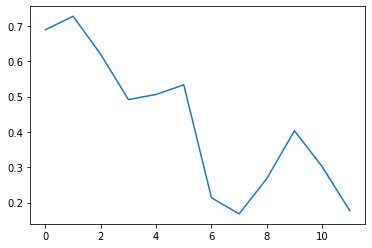

In [52]:
plt.plot(result.history['val_binary_accuracy'])
test_result = model.evaluate([X_test, np.array([counts_aa(xi) for xi in X_test])], y_test)
plt.show()

Let's see how the model works with classical positive-negative classification

In [52]:
labels = np.concatenate(
    (
        np.ones(pos_data.shape[0], dtype=pos_data.dtype),
        np.zeros(neg_data.shape[0], dtype=neg_data.dtype),
    ),
    axis=0,
)
features = np.concatenate((pos_data, neg_data), axis=0)
counts_features = np.array([counts_aa(xi) for xi in features])
shuffler = np.random.permutation(len(features))
features = features[shuffler]
counts_features = counts_features[shuffler]
labels = labels[shuffler]
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.1, random_state=25)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.2, random_state=25)

In [53]:
tf.keras.backend.clear_session()
model = build_model(L)
opt = tf.optimizers.Adam(lr_decayed_fn)
model.compile(
      opt,
      loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
      steps_per_execution = 60 if use_tpu else None,
      metrics=[tf.keras.metrics.AUC(from_logits=True), tf.keras.metrics.BinaryAccuracy(threshold=0)])

In [54]:
result = model.fit(
    [X_train, np.array([counts_aa(xi) for xi in X_train])], y_train, 
    validation_data=([X_val, np.array([counts_aa(xi) for xi in X_val])] , y_val),
    callbacks=[tf.keras.callbacks.LambdaCallback(
        on_epoch_begin=lambda epochs,logs: print('lr =',lr_decayed_fn(opt.iterations).numpy())
        ),
        tf.keras.callbacks.EarlyStopping(monitor='val_auc', mode='max', restore_best_weights=True, patience=5)],
    epochs=150)

Epoch 1/150
lr = 0.001
484/484 [==============================] - 26s 38ms/step - loss: 0.2788 - auc: 0.9180 - binary_accuracy: 0.8528 - val_loss: 0.2838 - val_auc: 0.9206 - val_binary_accuracy: 0.8422
Epoch 2/150
lr = 0.00099864
484/484 [==============================] - 16s 32ms/step - loss: 0.2587 - auc: 0.9279 - binary_accuracy: 0.8607 - val_loss: 0.2665 - val_auc: 0.9236 - val_binary_accuracy: 0.8516
Epoch 3/150
lr = 0.0009945672
484/484 [==============================] - 16s 33ms/step - loss: 0.2529 - auc: 0.9311 - binary_accuracy: 0.8663 - val_loss: 0.2663 - val_auc: 0.9236 - val_binary_accuracy: 0.8524
Epoch 4/150
lr = 0.0009878038
484/484 [==============================] - 16s 33ms/step - loss: 0.2526 - auc: 0.9315 - binary_accuracy: 0.8651 - val_loss: 0.2679 - val_auc: 0.9255 - val_binary_accuracy: 0.8604
Epoch 5/150
lr = 0.0009783866
484/484 [==============================] - 16s 33ms/step - loss: 0.2512 - auc: 0.9315 - binary_accuracy: 0.8673 - val_loss: 0.2607 - val_auc: 0

11/11 [==============================] - 0s 14ms/step - loss: 0.2467 - auc: 0.9434 - binary_accuracy: 0.8692


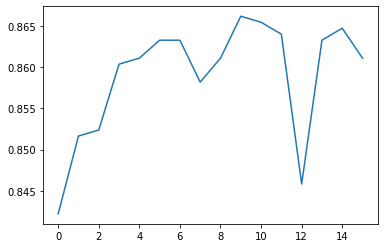

In [55]:
plt.plot(result.history['val_binary_accuracy'])
test_result = model.evaluate([X_test, np.array([counts_aa(xi) for xi in X_test])], y_test)
plt.show()